In [44]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [45]:
#Store the data into the df variable
SYMBOL = 'ETH'
df = pd.read_csv(f'../../data/{SYMBOL}.csv')

In [46]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values))
df['price'] = df[['high_price','low_price']].mean(axis=1)
#Show the dataframe
# df

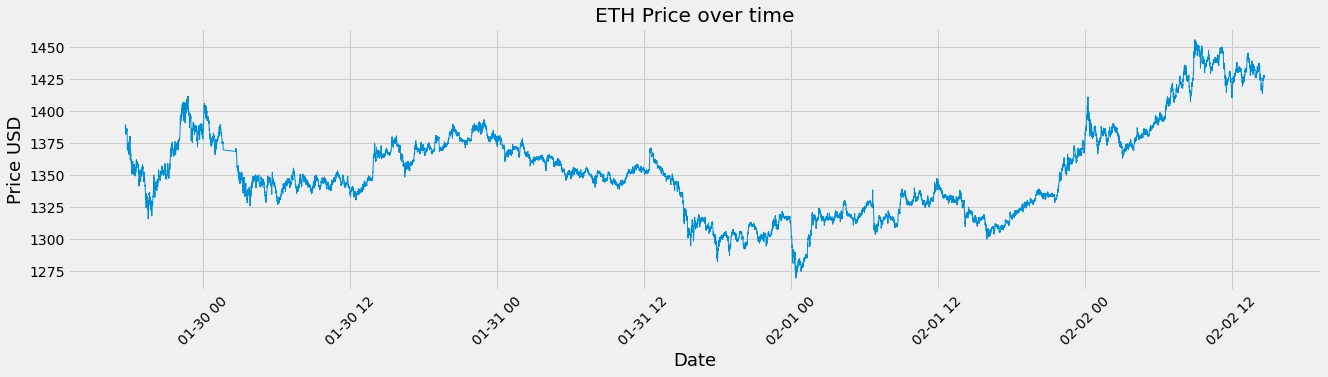

In [47]:
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.title(f"{SYMBOL} Price over time")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD',fontsize=18)
plt.show()

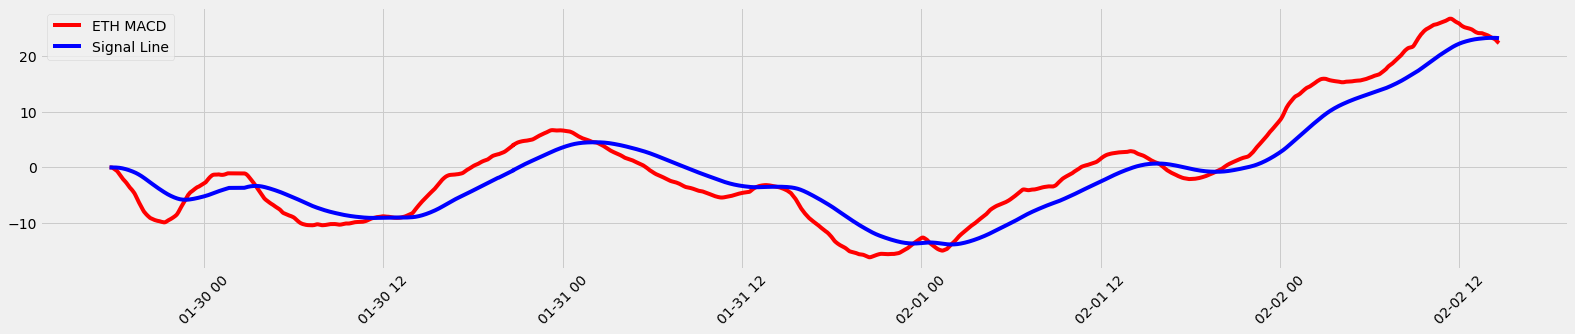

In [48]:

def createMacdAndSignalLines(dataset, macd_params, macd_multiplier):
    ShortEMA = dataset.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = dataset.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 9)
macd_multiplier = 170
# Best Multipliers for coins:
# ----------------------------
# ETH: 175, 178
# BCH: 50, 692
# LTC: none
smoothed_df = df.price.ewm(span=20, adjust=False).mean() #AKA Slow moving average
macd, signal = createMacdAndSignalLines(smoothed_df, macd_params, macd_multiplier)




plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, macd, label=f"{SYMBOL} MACD", color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
# for i in range(len(df)):
#     if np.sign(macd[i] - signal[i]) != np.sign(macd[i-1] - signal[i-1]):
#         plt.annotate(str(f"{df.price[i]:.0f}"), (df.index[i], macd[i]+.5))
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [49]:
df['MACD'] = macd
df['Signal Line'] = signal

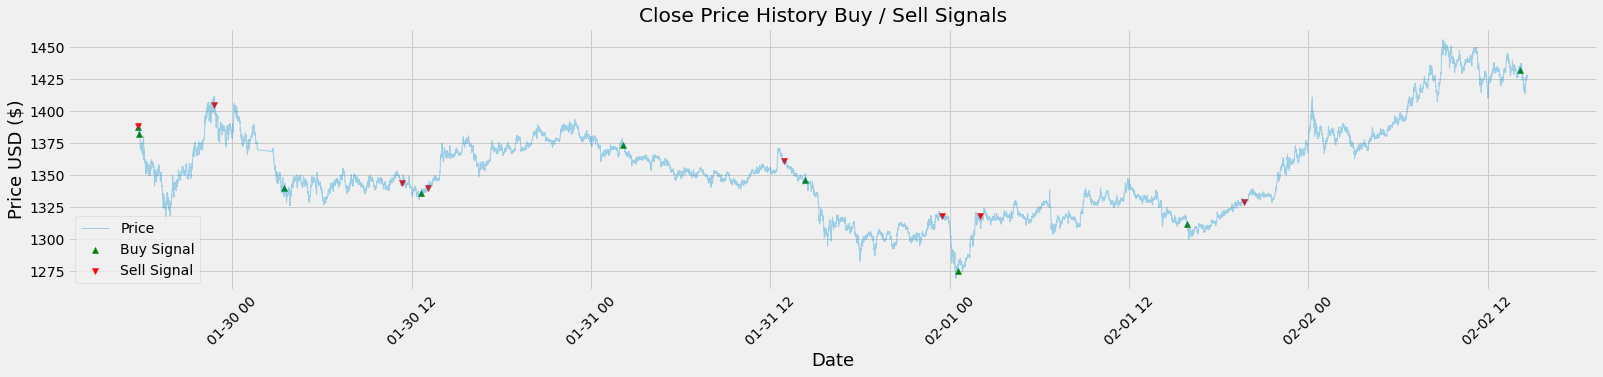

2021-01-29T17:41:30Z Bought at 1386.895  selling at 1392.39 for profit: 3.4950000000001182
2021-01-29T22:44:30Z Bought at 1385.685  selling at 1408.338657 for profit: 20.653657000000067
2021-01-30T11:22:15Z Bought at 1340.01  selling at 1339.61 for profit: -2.400000000000091
2021-01-30T13:06:45Z Bought at 1332.0  selling at 1335.525 for profit: 1.525000000000091
2021-01-31T12:56:30Z Bought at 1372.795  selling at 1365.085 for profit: -9.710000000000036
2021-01-31T23:28:15Z Bought at 1346.245  selling at 1322.01 for profit: -26.2349999999999
2021-02-01T02:00:00Z Bought at 1274.69  selling at 1322.475 for profit: 45.784999999999854
2021-02-01T19:42:00Z Bought at 1308.67  selling at 1333.325 for profit: 22.654999999999973
Profit 70.96865700000072
Transactions:  8


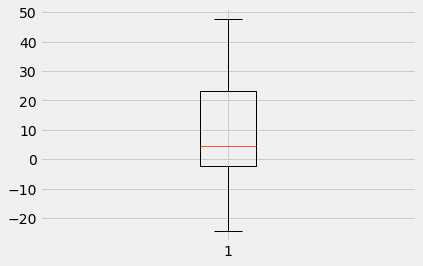

In [50]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(macd, signal, df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(1, len(signal)):
        if ( (macd.iat[i] < signal.iat[i]) and (macd.iat[i-1] >= signal.iat[i-1]) and bought == False):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        elif ( (macd.iat[i] > signal.iat[i]) and (macd.iat[i-1] <= signal.iat[i-1]) and bought):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], "Bought at", bought, " selling at", df.iat[i,1], "for profit:", df.iat[i,1] - bought - 2)
            transactions.append(df.iat[i,1] - bought)
            sumwin = sumwin + df.iat[i,1] - bought - .1
            bought = False 
    return(sumwin, transactions)


#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    #if MACD > signal line  then buy else sell
      if signal['MACD'][i] < signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD'][i] > signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

# Visually Show The Stock buy and sell signals
# Create the title 
title = 'Close Price History Buy / Sell Signals   '
#Get the stocks
my_stocks = df
  
#Create and plot the graph
plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['price'],  label='Price', alpha = 0.35, linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.legend( loc='lower left')
plt.show()

r = mac_daddy_tester(macd, signal, df)
print("Profit", r[0])
print("Transactions: ", len(r[1]))
plt.boxplot(r[1])
plt.show()

In [51]:
# Find optimal period value:
run_cell = True

if run_cell:
    results = []
    for period_length in np.arange(2, 700, 2):
        macd_params = (12, 26, 9)
        macd_multiplier = period_length #was 111
        macd, signal = createMacdAndSignalLines(smoothed_df, macd_params, macd_multiplier)
        r = mac_daddy_tester(macd, signal, df, quiet=True)
        results.append((period_length, r[0], len(r[1])))
        # print(period_length, "Profit", r[0], "transactions: ", len(r[1]))

    results.sort(key = lambda x: -x[1])
    for tup in results[:25]:
        print(f"Profit: ${tup[1]:.2f} Period Param: {tup[0]} Transactions: {tup[2]}")

Profit: $172.27 Period Param: 16 Transactions: 58
Profit: $149.67 Period Param: 18 Transactions: 54
Profit: $142.79 Period Param: 34 Transactions: 27
Profit: $109.17 Period Param: 30 Transactions: 32
Profit: $106.38 Period Param: 14 Transactions: 64
Profit: $90.86 Period Param: 2 Transactions: 274
Profit: $86.42 Period Param: 36 Transactions: 29
Profit: $86.39 Period Param: 28 Transactions: 35
Profit: $86.07 Period Param: 40 Transactions: 26
Profit: $84.78 Period Param: 152 Transactions: 7
Profit: $83.12 Period Param: 20 Transactions: 48
Profit: $82.14 Period Param: 24 Transactions: 39
Profit: $78.23 Period Param: 38 Transactions: 25
Profit: $78.22 Period Param: 8 Transactions: 93
Profit: $76.43 Period Param: 10 Transactions: 81
Profit: $72.01 Period Param: 26 Transactions: 37
Profit: $70.97 Period Param: 170 Transactions: 8
Profit: $70.33 Period Param: 12 Transactions: 69
Profit: $68.54 Period Param: 174 Transactions: 8
Profit: $66.35 Period Param: 148 Transactions: 7
Profit: $65.04 P